# Label Clustering

Explanation

In [1]:
import ast
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram, linkage

_ = load_dotenv()

In [2]:
# Data import
DATA_PATH = Path(os.getenv('PROJECT_ROOT'), '.') / 'data'
TRACKS_FILE = DATA_PATH / 'spotify_track_genres_preprocessed.csv'

tracks = pd.read_csv(TRACKS_FILE)
tracks['artist_genres'] = tracks['artist_genres'].apply(ast.literal_eval)
tracks['artist_ids'] = tracks['artist_ids'].apply(ast.literal_eval)

We only need the tracks and genres

In [3]:
track_genres = tracks[['track_id', 'artist_genres']].copy()

In [4]:
track_genre_exp = track_genres[['artist_genres']].explode('artist_genres')
genre_counts = track_genre_exp['artist_genres'].value_counts()
all_genres = genre_counts.reset_index()['artist_genres']

We should still filter the genres.

In [ ]:
GENRE_THRESHOLD = 50
excluded_genre_subset = genre_counts[genre_counts < GENRE_THRESHOLD]
excluded_genre_subset.head(10)

As we can see...

In [ ]:
GENRE_THRESHOLD = 10
excluded_genre_subset_10 = genre_counts[genre_counts < GENRE_THRESHOLD]
excluded_genre_subset_10.head(10)

This is better

In [5]:
total_genres = genre_counts.size
filtered_genre_counts = genre_counts[genre_counts >= GENRE_THRESHOLD]
filtered_genre_list = filtered_genre_counts.reset_index()['artist_genres'].to_list()
print(f'Number of genres meeting or exceeding {GENRE_THRESHOLD} tracks: {len(filtered_genre_list)}')
print(f'{total_genres - len(filtered_genre_list)} of {total_genres} genres removed from dataset.')

Number of genres meeting or exceeding 10 tracks: 591
1396 of 1987 genres removed from dataset.


This still significantly reduces the label space, making further clustering efforts easier since they will need manual intervention.

In [6]:
# def filter_tracks_by_genre(track_df: pd.DataFrame, genre_subset_series: pd.Series, track_genre_exploded_df: pd.DataFrame = None) -> pd.DataFrame:
#     
#     # Optional, since exploding the DF is expensive in memory
#     if track_genre_exploded_df is None:
#         track_genre_exploded_df = track_df[['artist_genres']].explode('artist_genres')
#     
#     filtered_track_genre_exp = track_genre_exploded_df[track_genre_exploded_df['artist_genres'].isin(genre_subset_series)]
#     track_filtered_genre_pivot = pd.pivot_table(filtered_track_genre_exp, index=filtered_track_genre_exp.index, columns='artist_genres', aggfunc=lambda x: 1, fill_value=0)
#     
#     track_df_filtered = track_df.merge(track_filtered_genre_pivot, left_index=True, right_index=True, how='inner').reset_index(drop=True)
#     track_df_filtered[genre_subset_series] = track_df_filtered[genre_subset_series].fillna(0)
#     track_df_filtered[genre_subset_series] = track_df_filtered[genre_subset_series].astype(int)
#     
#     return track_df_filtered

In [7]:
# track_data_10 = filter_tracks_by_genre(track_genres, filtered_genre_subset, track_genre_exp)
# 
# print(f'After filtering, {100 * track_data_10.shape[0] / tracks.shape[0]:.1f}% of the dataset remains, {track_data_10.shape[0]} of {tracks.shape[0]} tracks.')

After filtering, 94.1% of the dataset remains, 9804 of 10416 tracks.


In [19]:
adj = pd.DataFrame(0, index=filtered_genre_list, columns=filtered_genre_list)

for genres in track_genres['artist_genres']:
    for genre1 in genres:
        if genre1 in filtered_genre_list:
            for genre2 in genres:
                if genre1 != genre2 and genre2 in filtered_genre_list:
                    adj.at[genre1, genre2] += 1

Get binary to eliminate sample bias

In [20]:
bin_adj = adj.clip(upper=1)

Also calculate norm-weighted adjacency to maintain some of the relevant data from frequency

In [23]:
counts_array = filtered_genre_counts.values
norm_factors = np.outer(counts_array, counts_array)
norm_adj_array = np.divide(adj.values, np.sqrt(norm_factors), where=norm_factors != 0)
norm_adj = pd.DataFrame(norm_adj_array, index=filtered_genre_list, columns=filtered_genre_list)

Use the adjacencies to generate linkage matrices, generate dendrograms. Trial and error processes that involved subjective decision-making. Tuning clustering method, which adjacency to use, distance cutoff value.

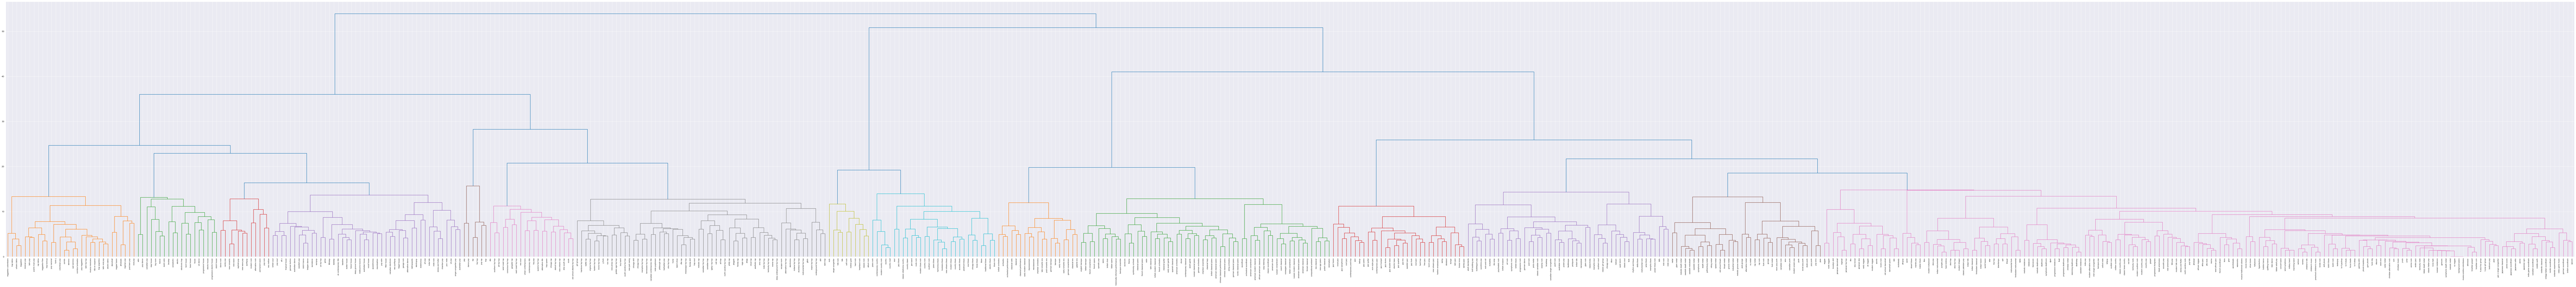

In [52]:
bin_dist = 1 - bin_adj
bin_linkage_ward = linkage(bin_dist, method='ward')
plt.figure(figsize=(200, 20))
dendrogram(bin_linkage_ward, labels=filtered_genre_list, color_threshold=0.3 * max(bin_linkage_ward[:, 2]), leaf_font_size=8)
plt.show()

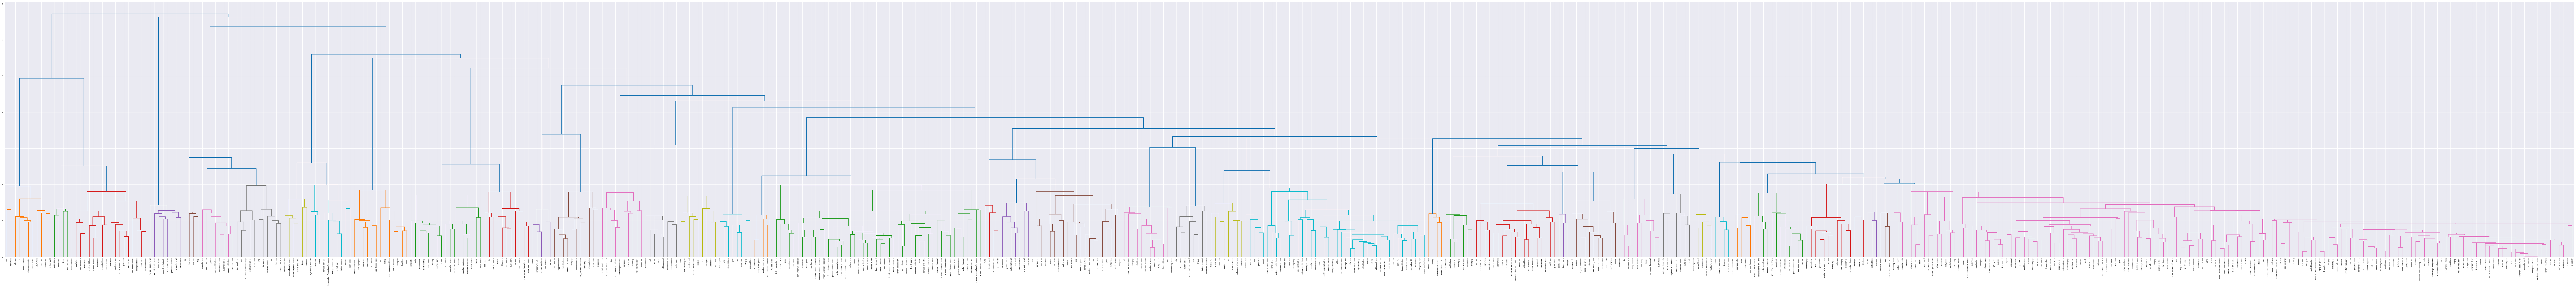

In [261]:
norm_dist = 1 - norm_adj
norm_linkage_ward = linkage(norm_dist, method='ward')
plt.figure(figsize=(200, 20))
dendrogram(norm_linkage_ward, labels=filtered_genre_list, color_threshold=0.3 * max(norm_linkage_ward[:, 2]), leaf_font_size=8)
plt.show()

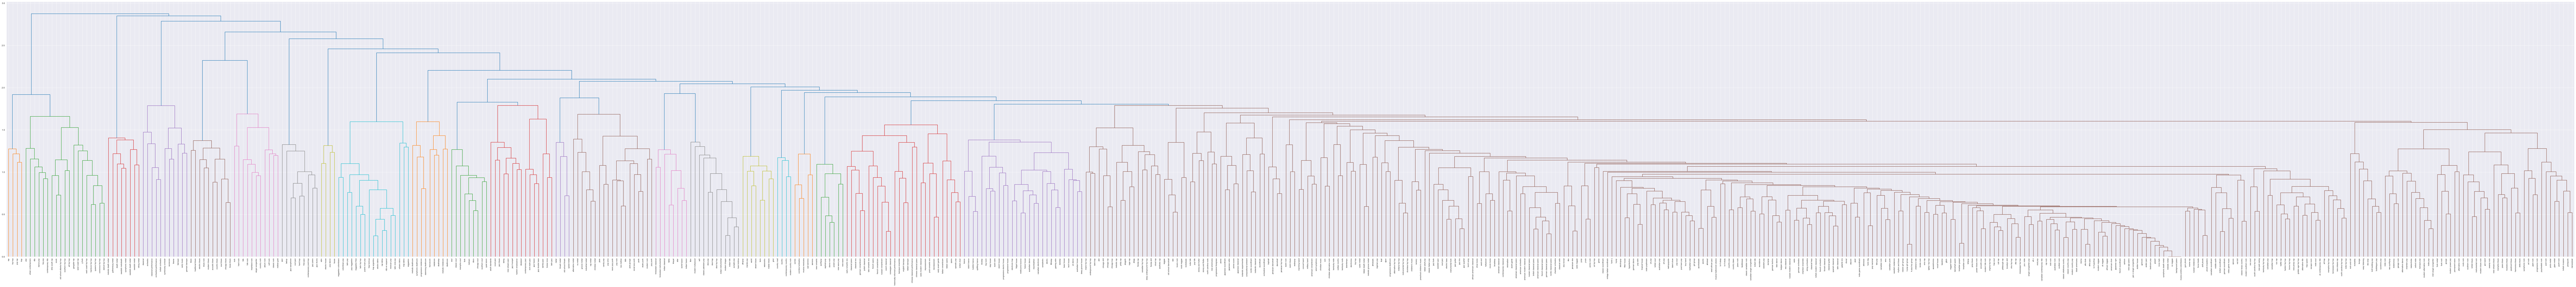

In [49]:
norm_linkage_complete = linkage(norm_dist, method='complete')
plt.figure(figsize=(200, 20))
dendrogram(norm_linkage_complete, labels=filtered_genre_list, color_threshold=1.8, leaf_font_size=8)
plt.show()

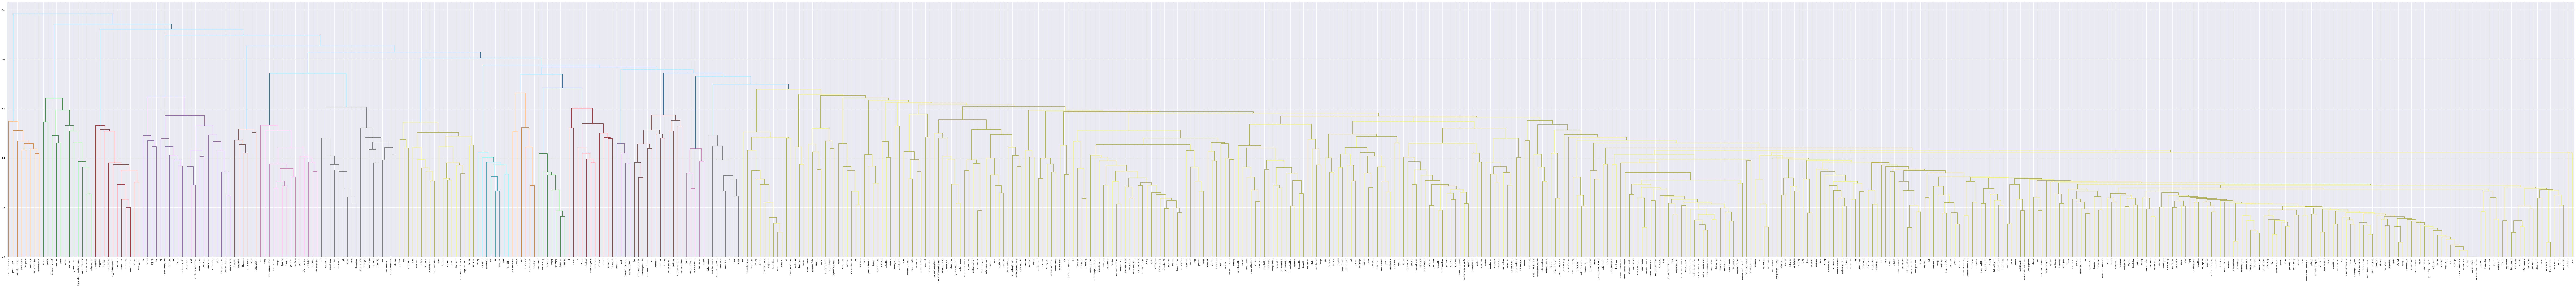

In [50]:
norm_linkage_weighted = linkage(norm_dist, method='weighted')
plt.figure(figsize=(200, 20))
dendrogram(norm_linkage_weighted, labels=filtered_genre_list, color_threshold=1.7, leaf_font_size=8)
plt.show()

A significant portion of the trial and error has been excluded from the notebook for clarity and memory reasons (the images are quite large due to the number of labels and the image size needed to read and distinguish them). The best initial clustering is from the normalized adjacency and ward clustering. I define best as:
- creating clusters that are distinct from one another
- cluster genres make sense together
- clusters are not overly broad or specific
- if they are specific, it is straightforward to combine with another similar cluster manually
- "catch-all" cluster size of uncategorized genres is small relative to the percentage of labels in it

In [262]:
from scipy.cluster.hierarchy import fcluster

norm_linkage = norm_linkage_ward
distance_cutoff = 0.3 * max(norm_linkage[:, 2])
clusters = fcluster(norm_linkage, distance_cutoff, criterion='distance')

In [460]:
cluster_genre_lists = {}
for genre, cluster in zip(filtered_genre_list, clusters):
    if cluster not in cluster_genre_lists:
        cluster_genre_lists[cluster] = [genre]
    else:
        cluster_genre_lists[cluster] += [genre]
cluster_genre_lists = {cluster: cluster_genre_lists[cluster] for cluster in sorted(list(cluster_genre_lists.keys()))}

In [461]:
cluster_top_genres = {}
for cluster_id, genres in cluster_genre_lists.items():
    genres_sorted = sorted(genres, key=lambda x: filtered_genre_counts.get(x, 0), reverse=True)
    top_genres = genres_sorted[:5]
    top_genres_padded = top_genres + [None] * (5 - len(top_genres))
    cluster_top_genres[cluster_id] = top_genres_padded

In [462]:
top_genres_df = pd.DataFrame.from_dict(cluster_top_genres, orient='index', columns=['Genre ' + str(i) for i in range(5)])

In [463]:
top_genres_df.to_csv(DATA_PATH / 'top_genres.csv')

In [464]:
top_genres_consolidated = pd.read_csv(DATA_PATH/'top_genres_consolidated.csv', index_col='Unnamed: 0', usecols=['Unnamed: 0', 'Cluster', 'Combine'], keep_default_na=False, na_values=None)

Lots of explanation here

In [465]:
cluster_genres = cluster_genre_lists.copy()
cluster_genres['pop'] = []
cluster_genres['r&b'] = []

In [467]:
for i, row in top_genres_consolidated.iterrows():
    if row['Cluster']:
        cluster_genres[row['Cluster']] = cluster_genres.pop(i)
        
for i, row in top_genres_consolidated.iterrows():
    if row['Combine']:
        cluster_genres[row['Combine']] += cluster_genres.pop(i)

In [480]:
def manually_move_genres(genre_list, from_cluster, to_cluster, cluster_dict):
    for genre_name in genre_list:
        cluster_dict[from_cluster].remove(genre_name)
        cluster_dict[to_cluster].append(genre_name)

In [481]:
cluster_genres['pop and r&b']

['pop',
 'dance pop',
 'r&b',
 'southern hip hop',
 'urban contemporary',
 'atl hip hop',
 'hip pop',
 'dirty south rap',
 'contemporary r&b',
 'crunk',
 'old school atlanta hip hop']

In [483]:
manually_move_genres(['pop', 'dance pop', 'hip pop'], 'pop and r&b', 'pop', cluster_genres)
manually_move_genres(['r&b', 'urban contemporary','contemporary r&b'], 'pop and r&b', 'r&b', cluster_genres)
manually_move_genres(cluster_genres['pop and r&b'].copy(), 'pop and r&b', 'hip hop', cluster_genres)

In [484]:
del cluster_genres['pop and r&b']

In [485]:
cluster_genres['new wave and synthpop']

['new wave pop',
 'new romantic',
 'new wave',
 'synthpop',
 'dance rock',
 'sophisti-pop',
 'power pop']

In [486]:
manually_move_genres(['new wave pop', 'new romantic', 'new wave', 'dance rock', 'power pop'], 'new wave and synthpop', 'rock', cluster_genres)
manually_move_genres(['synthpop', 'sophisti-pop'], 'new wave and synthpop', 'pop', cluster_genres)
del cluster_genres['new wave and synthpop']

In [487]:
cluster_genres['japanese']

['anime score',
 'anime',
 'japanese soundtrack',
 'japanese classical',
 'japanese celtic']

In [488]:
manually_move_genres(['anime score', 'anime', 'japanese soundtrack'], 'japanese', 'soundtrack', cluster_genres)
manually_move_genres(['japanese classical', 'japanese celtic'], 'japanese', 'world', cluster_genres)
del cluster_genres['japanese']

In [489]:
cluster_genres['indie rock and electronica']

['indie rock',
 'indietronica',
 'art pop',
 'melancholia',
 'garage rock',
 'chamber pop',
 'electronica',
 'modern alternative rock',
 'trip hop',
 'downtempo',
 'baroque pop',
 'alternative dance',
 'neo-synthpop',
 'oxford indie']

In [490]:
manually_move_genres(['indietronica', 'art pop', 'melancholia', 'chamber pop','electronica', 'trip hop', 'downtempo', 'baroque pop', 'alternative dance', 'neo-synthpop' ], 'indie rock and electronica', 'pop', cluster_genres)
manually_move_genres(['indie rock', 'garage rock', 'modern alternative rock', 'oxford indie'], 'indie rock and electronica', 'rock', cluster_genres)
del cluster_genres['indie rock and electronica']

In [491]:
cluster_genres['dutch genres']

['dutch blues', 'dutch rock', 'nederpop']

In [492]:
manually_move_genres(['dutch blues' ], 'dutch genres', 'blues', cluster_genres)
manually_move_genres(['dutch rock'], 'dutch genres', 'rock', cluster_genres)
manually_move_genres(['nederpop'], 'dutch genres', 'pop', cluster_genres)
del cluster_genres['dutch genres']

In [493]:
manually_move_genres(['folk'], 'rock', 'folk', cluster_genres)
manually_move_genres(['country rock'], 'rock', 'country', cluster_genres)
manually_move_genres(['alternative r&b'], 'hip hop', 'r&b', cluster_genres)

In [494]:
catch_all = pd.Series(cluster_genres.pop('catch-all'))

In [495]:
list(cluster_genres.keys())

['pop',
 'r&b',
 'rock',
 'blues',
 'hip hop',
 'classical',
 'jazz',
 'electronic',
 'latin american pop',
 'world',
 'metal',
 'bollywood',
 'country',
 'adult standards',
 'reggae',
 'folk',
 'military',
 'caribbean',
 'soundtrack',
 'gospel']

In [496]:
catch_all.to_csv(DATA_PATH / 'catch_all_genres.csv', header=None, index=False)

In [497]:
catch_all_map = pd.read_csv(DATA_PATH / 'catch_all_genres_map.csv', header=None)

In [499]:
cluster_genres['lo-fi'] = []
cluster_genres['childrens'] = []
cluster_genres['show tunes'] = []

for _, row in catch_all_map.iterrows():
    cluster_genres[row[1]].append(row[0])

In [501]:
genre_count_check = 0
for cluster_name, genre_list in cluster_genres.items():
    for genre in genre_list:
        genre_count_check += 1
print(genre_count_check)

591
